In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    read_csv_from_web,
    implementPairDecayLimit,
    fromHB5Table1,
    relevantGridEntries,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# CMS 13TeV LHC

## `hSM > h h > mumu bb` [1812.06359](https://arxiv.org/abs/1812.06359)


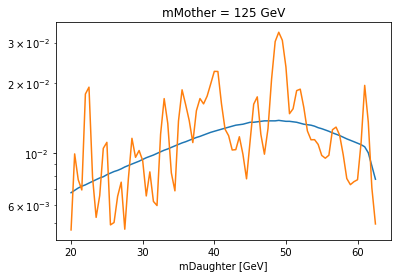

Looks good. Saving this to comb_LHC13_CMS_36.json


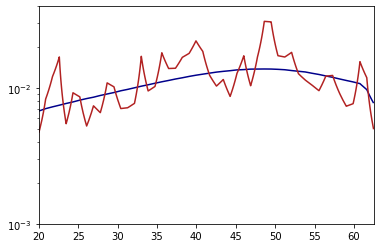

In [2]:
df = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1709317/Table1/1/csv",
    comment="#",
    skiprows=194,
    skipfooter=555 - 281,
    engine="python",
    names=["mDaughter1", "exp"],
)

dfObs = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1709317/Table1/1/csv",
    comment="#",
    skiprows=467,
    names=["m", "obs"],
)
assert np.allclose(df.mDaughter1, dfObs.m)
df["obs"] = dfObs.obs
del dfObs
df["mMother"] = 125

df.obs *= 1e-3  # fb to pb
df.exp *= 1e-3  # fb to pb
limitFile = implementPairDecayLimit(
    "1812.06359",
    {
        "production": ["H", "vbfH"],
        "firstDecay": ["mumu"],
        "secondDecay": ["bb"],
    },
    "https://www.hepdata.net/record/ins1709317",
    df,
    massResolution={
        "firstDaughter": resolution.mumu["light"],
        "secondDaughter": resolution.bb["medMass"],
        "mother": {
            "absolute": 20,
            "relative": 0,
        },  # guess, they don't give any numbers
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("bb", 1.0)
h2.setDecayWidth("mumu", 1.0)
hh.setMass(125)
hm = np.linspace(20, 62.5)
r = np.linspace(1e-3, 4e-2)


def testAgainstLimit(mass, rate):
    h1.setMass(mass)
    h2.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


# CMS 8TeV LHC

## `hSM > h h > mumu bb` [1701.02032](https://arxiv.org/abs/1701.02032)

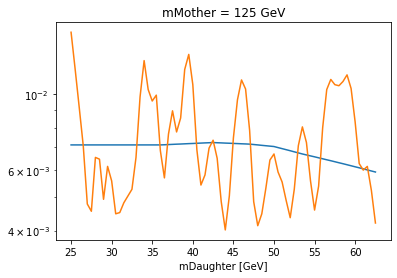

Looks good. Saving this to H_LHC8_CMS_20.json


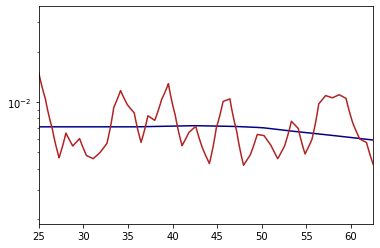

In [3]:
df = fromHB5Table1("170102032_CMS_HSM-aa-mumubb_19.7fb-1", "CMS").rename(
    columns={"m": "mDaughter1"}
)
df["mMother"] = 125
prodModes = ["H"]
ref = HP.SMHiggs(125)
refCxn = np.sum([ref.cxn("LHC8", p) for p in prodModes])
df.obs *= refCxn
df.exp *= refCxn
limitFile = implementPairDecayLimit(
    "1701.02032",
    {
        "production": prodModes,
        "firstDecay": ["mumu"],
        "secondDecay": ["bb"],
    },
    "Fig. 5",
    df,
    idSuffix=2,  # 1 is mumutautau
    massResolution={
        "firstDaughter": resolution.mumu["light"],
        "secondDaughter": resolution.bb["medMass"],  # bb
        "mother": {
            "absolute": 50,
            "relative": 0,
        },  # given for the mumutautau case, certainly not better here
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("bb", 1.0)
h2.setDecayWidth("mumu", 1.0)
hh.setMass(125)
hm = np.linspace(25, 62.5)
r = np.linspace(1e-4, 2e-3)


def testAgainstLimit(mass, rate):
    h1.setMass(mass)
    h2.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate * refCxn)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r * refCxn, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r * refCxn, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()
